# Análisis y Procesamiento de Imágenes
Este notebook implementa un flujo de trabajo completo para el análisis de imágenes, limpieza, preprocesamiento, extracción de características y despliegue.


### 1. Análisis Exploratorio (Similitudes y Diferencias)


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Ruta al directorio de imágenes
image_folder = 'circuits/'

# Obtener una lista de archivos de imagen válidos en el directorio
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# Cargar imágenes
images = [cv2.imread(img_path) for img_path in image_files]

# Verificar que todas las imágenes se cargaron correctamente
for i, (img, img_path) in enumerate(zip(images, image_files)):
    if img is None:
        print(f'Error: No se pudo cargar la imagen {img_path}.')
    else:
        print(f'Imagen {i+1} ({img_path}) cargada correctamente.')

# Mostrar imágenes en una cuadrícula
plt.figure(figsize=(20, 10))
for i, img in enumerate(images):
    if img is not None:  # Verificar si la imagen es válida antes de mostrarla
        plt.subplot(4, 5, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.suptitle('Visualización de Imágenes', fontsize=16)
plt.show()

### Histogramas de Colores


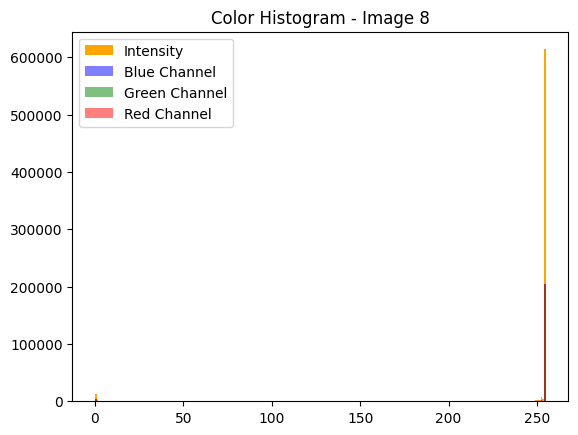

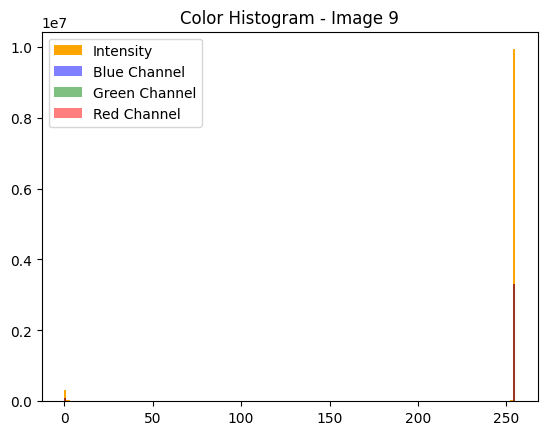

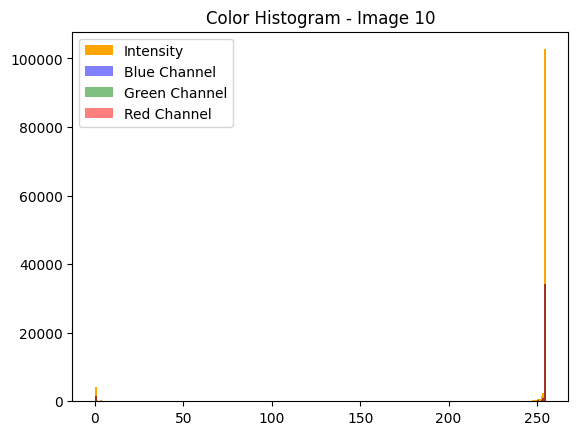

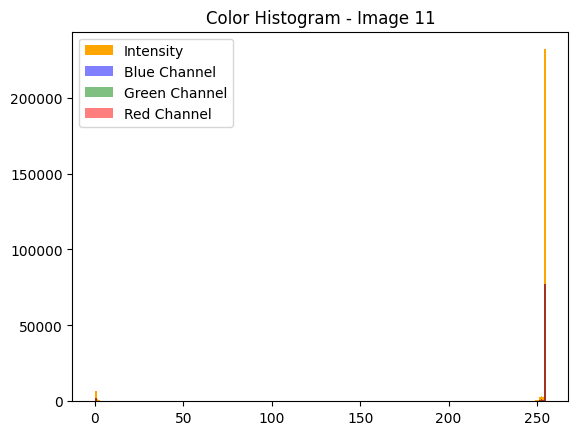

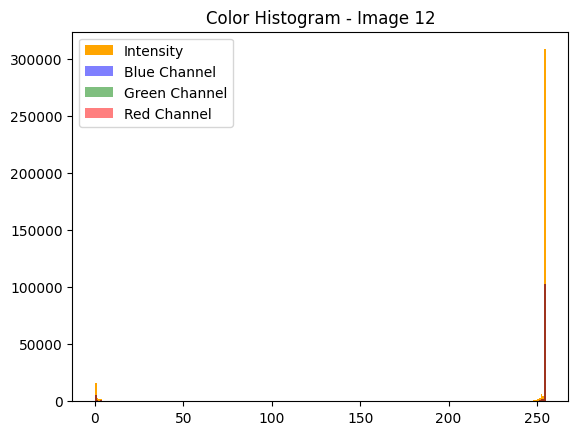

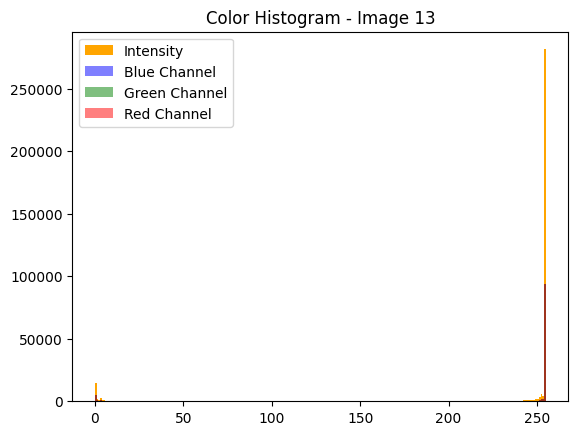

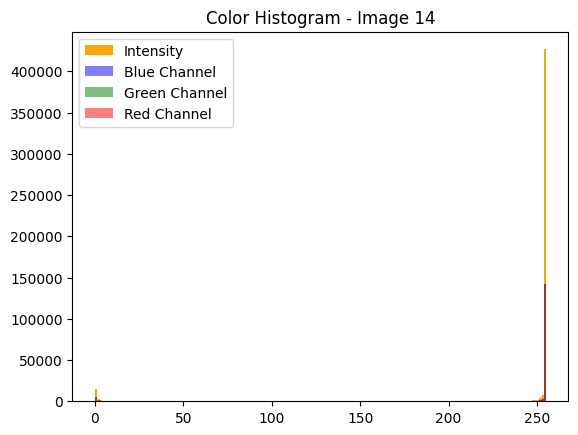

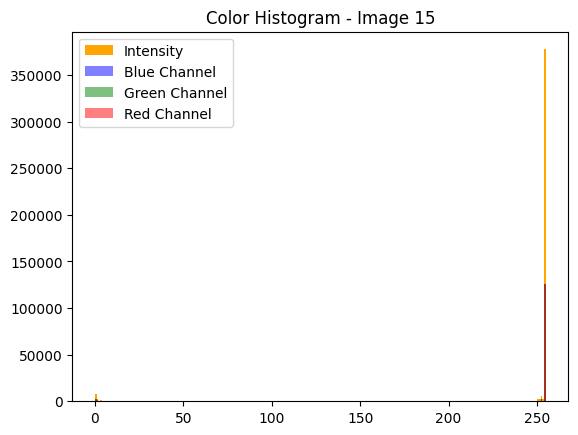

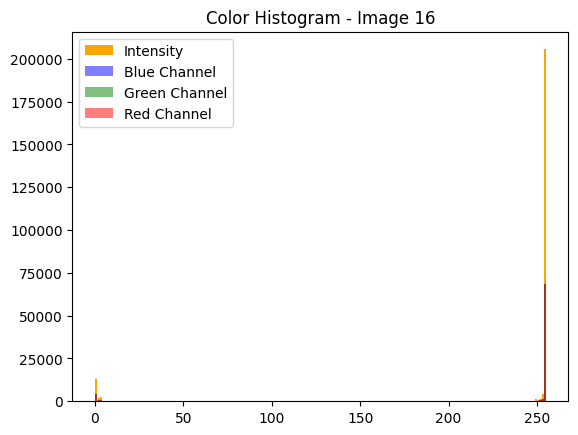

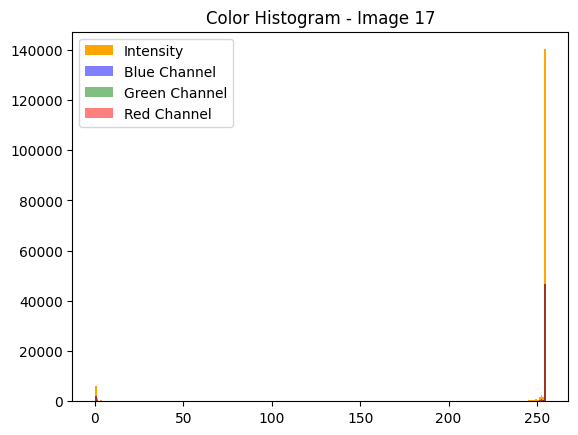

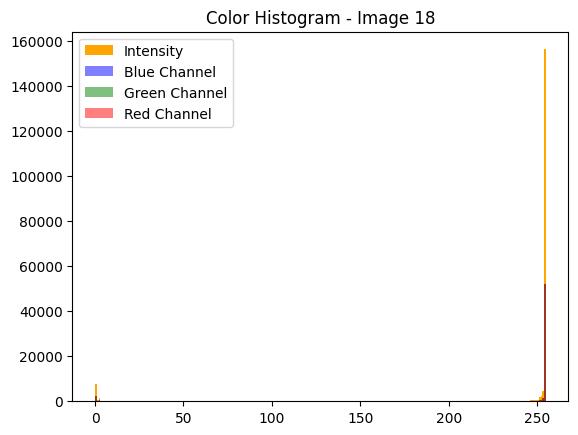

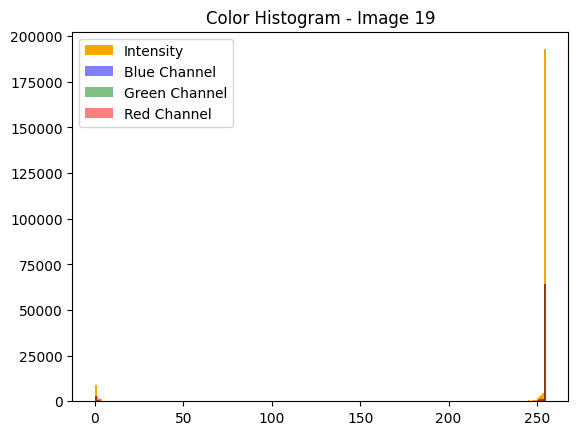

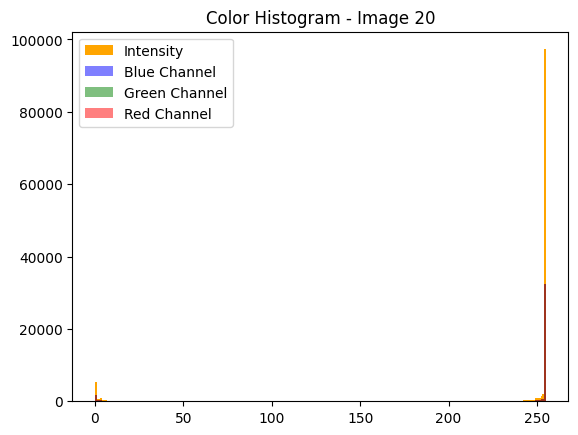

In [17]:
for i, img in enumerate(images):
    plt.figure()
    plt.hist(img.ravel(), bins=256, color='orange', label='Intensity')
    plt.hist(img[:, :, 0].ravel(), bins=256, color='blue', alpha=0.5, label='Blue Channel')
    plt.hist(img[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, label='Green Channel')
    plt.hist(img[:, :, 2].ravel(), bins=256, color='red', alpha=0.5, label='Red Channel')
    plt.title(f'Color Histogram - Image {i+1}')
    plt.legend()
    plt.show()

## 2. Técnicas de Limpieza

In [26]:
# Comprobar imágenes corruptas
for i, img in enumerate(images):
    if img is None:
        print(f'La imagen {i+1} está corrupta o no se pudo abrir.')

# Detectar duplicados usando SSIM
def are_images_similar(img1, img2):
    if img1.shape != img2.shape:
        return False
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(gray1, gray2, full=True)
    return score > 0.95

duplicates = []
for i in range(len(images)):
    for j in range(i + 1, len(images)):
        if are_images_similar(images[i], images[j]):
            duplicates.append((i, j))
print(f'Pares de imágenes duplicadas: {duplicates}')


Pares de imágenes duplicadas: []


## 3. Preprocesamiento y Aumento de Datos

In [28]:
# Redimensionar y normalizar las imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el tamaño objetivo para redimensionar las imágenes (224x224)
target_size = (224, 224)

# Redimensionar todas las imágenes al tamaño objetivo
resized_images = [cv2.resize(img, target_size) for img in images]

# Normalizar las imágenes dividiendo entre 255.0 para tener valores en el rango [0, 1]
normalized_images = [img / 255.0 for img in resized_images]

# Aumento de datos: aplicar transformaciones aleatorias a las imágenes para crear variaciones
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotación aleatoria de las imágenes en un rango de 20 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Aplicar cizallamiento aleatorio
    zoom_range=0.2,  # Zoom aleatorio en las imágenes
    horizontal_flip=True,  # Voltear las imágenes horizontalmente de forma aleatoria
    fill_mode='nearest'  # Rellenar los píxeles vacíos con los valores más cercanos
)

# Crear un conjunto de imágenes aumentadas
augmented_images = []
for img in normalized_images:
    img = np.expand_dims(img, axis=0)  # Expandir dimensiones para que sea compatible con el generador
    aug_iter = datagen.flow(img, batch_size=1)  # Crear un iterador para generar imágenes aumentadas
    augmented_images.extend([next(aug_iter)[0] for _ in range(5)])  # Generar 5 imágenes aumentadas por cada imagen original


## 4. Extracción de Características y Detección

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


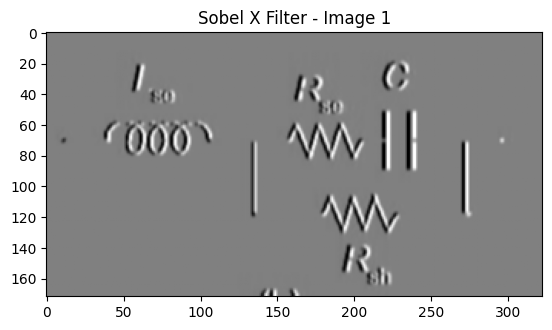

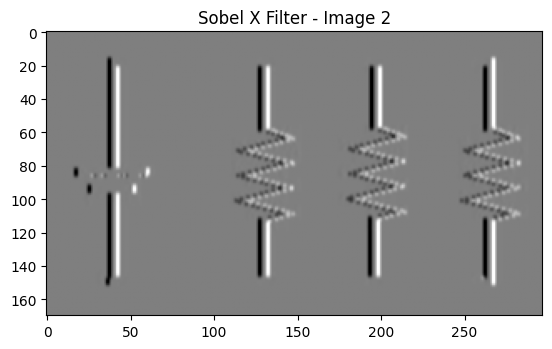

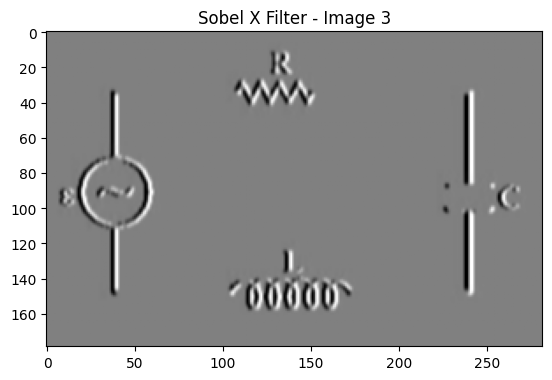

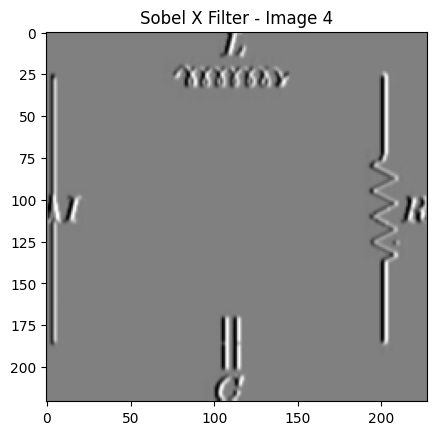

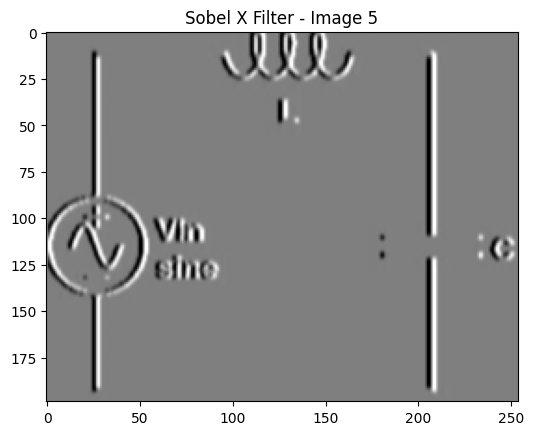

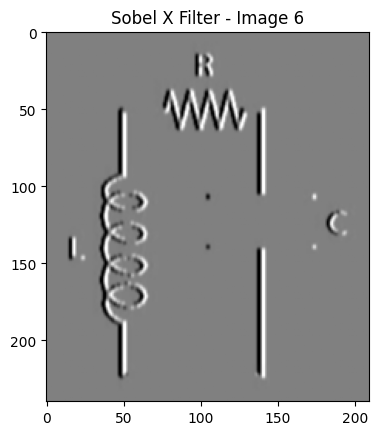

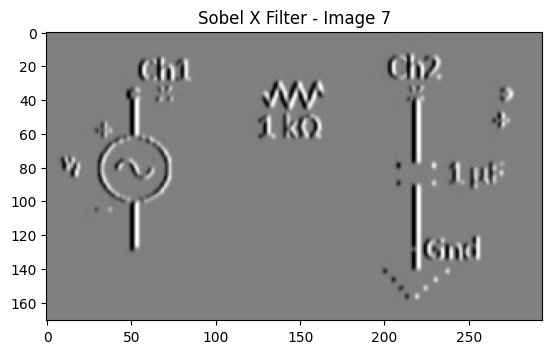

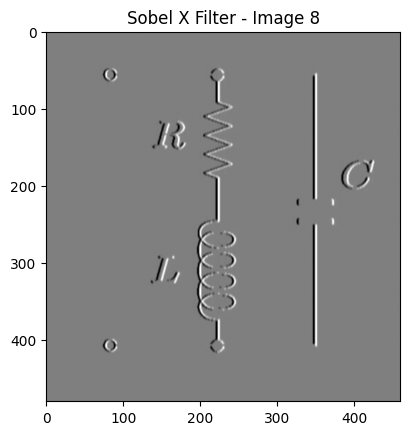

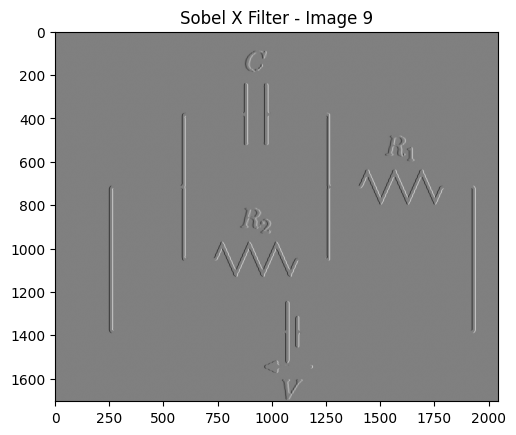

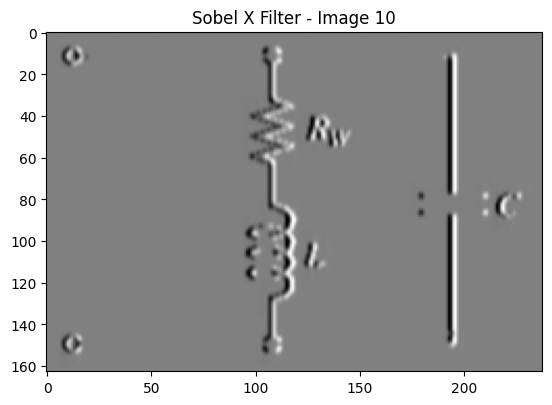

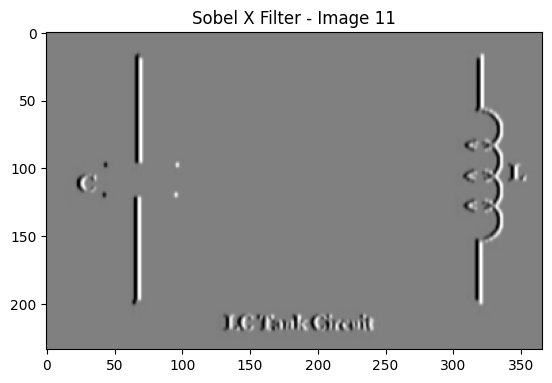

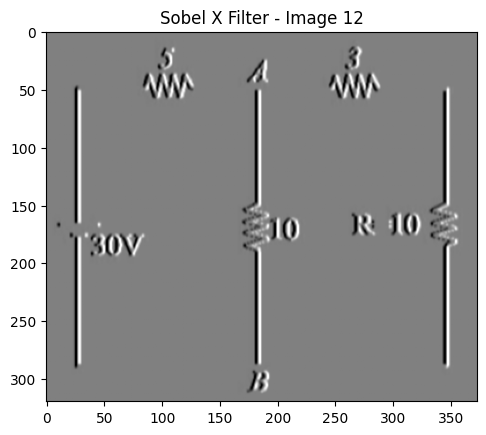

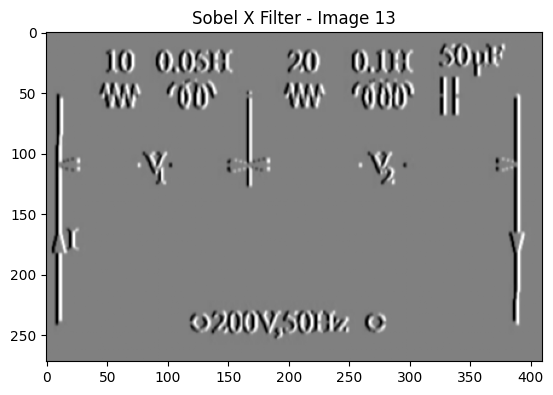

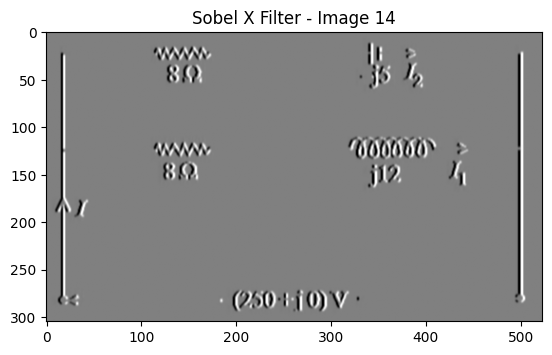

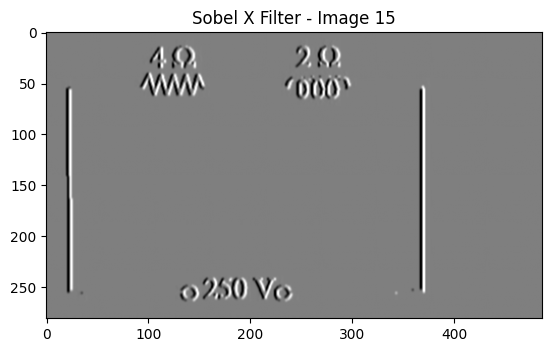

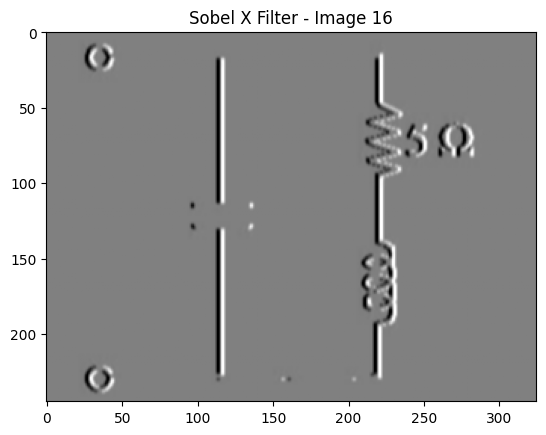

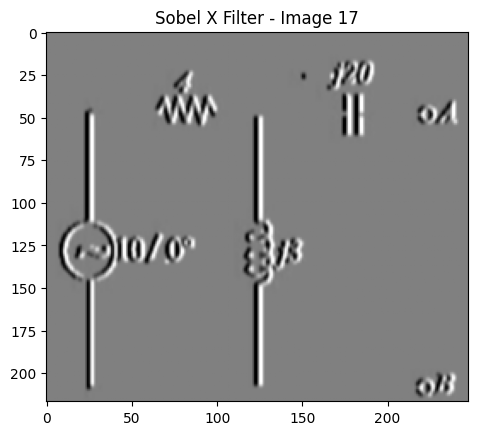

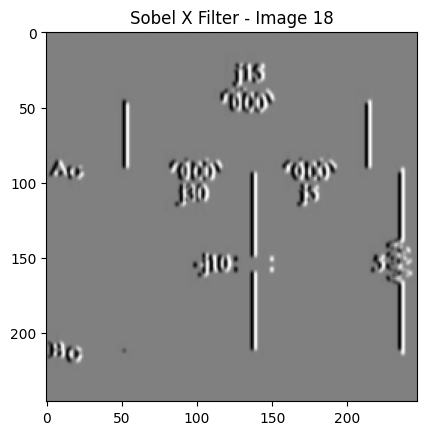

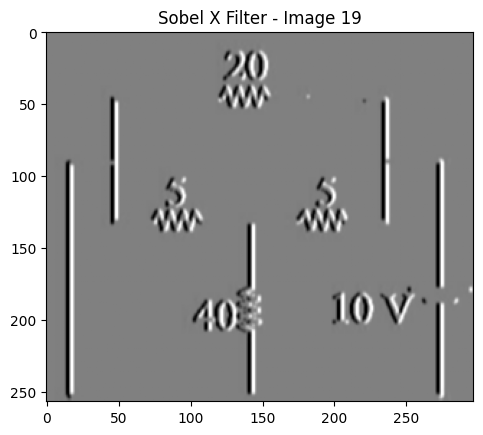

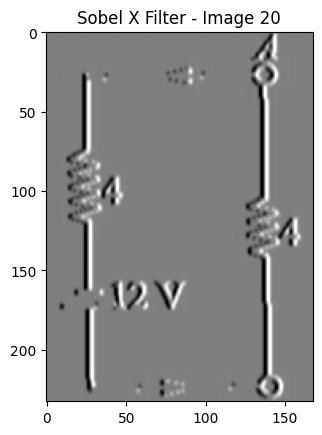

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Feature extraction using VGG16
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = [model.predict(preprocess_input(np.expand_dims(img, axis=0))) for img in normalized_images]

# Texture analysis using Sobel filter
for i, img in enumerate(images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    plt.figure()
    plt.imshow(sobelx, cmap='gray')
    plt.title(f'Sobel X Filter - Image {i+1}')
    plt.show()

## 5. Métricas

In [21]:
# Calcular el MSE (Error Cuadrático Medio) entre imágenes normalizadas
from skimage.metrics import mean_squared_error as mse

# Calcular MSE entre las imágenes normalizadas
for i in range(len(normalized_images)):
    for j in range(i + 1, len(normalized_images)):
        mse_value = mse(normalized_images[i], normalized_images[j])
        print(f'MSE entre la imagen {i+1} y la imagen {j+1}: {mse_value}')


MSE between image 1 and image 2: 0.12048243786893838
MSE between image 1 and image 3: 0.06776373090085704
MSE between image 1 and image 4: 0.054320885216831746
MSE between image 1 and image 5: 0.08376403512794006
MSE between image 1 and image 6: 0.07187817314425761
MSE between image 1 and image 7: 0.07126699035414821
MSE between image 1 and image 8: 0.05643367773988678
MSE between image 1 and image 9: 0.06958973642561596
MSE between image 1 and image 10: 0.06842791324045955
MSE between image 1 and image 11: 0.0641371684498962
MSE between image 1 and image 12: 0.09317204874188216
MSE between image 1 and image 13: 0.08753352893444959
MSE between image 1 and image 14: 0.06705764372742562
MSE between image 1 and image 15: 0.062051554281843446
MSE between image 1 and image 16: 0.10088758655014275
MSE between image 1 and image 17: 0.08127054610651444
MSE between image 1 and image 18: 0.08089318192554786
MSE between image 1 and image 19: 0.09405308375392644
MSE between image 1 and image 20: 0

## 6. Deployment

Configuración de Flask y modelo

In [22]:
# Inicializar la aplicación Flask
from flask import Flask, request, jsonify

app = Flask(__name__)

# Ruta donde se guardarán las imágenes
UPLOAD_FOLDER = 'circuits'
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)

# Cargar el modelo VGG16 (o el que estés usando)
model = VGG16(weights='imagenet')


Definición de la ruta /predict

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['image']
    
    # Guardar la imagen en el directorio /circuits
    image_path = os.path.join(UPLOAD_FOLDER, file.filename)
    file.save(image_path)
    
    # Procesar la imagen
    image = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
    image = cv2.resize(image, (224, 224))  # Redimensionar a 224x224, tamaño esperado por VGG16
    image = np.expand_dims(image, axis=0)  # Expande las dimensiones de la imagen para que tenga forma (1, 224, 224, 3)
    image = preprocess_input(image)  # Preprocesamiento específico para VGG16
    
    # Realizar predicción
    preds = model.predict(image)
    
    # Retornar los resultados como JSON
    return jsonify(preds.tolist())


niciar el servidor de Flask

In [24]:
from threading import Thread

def run_flask():
    app.run(debug=True, use_reloader=False)

# Ejecutar Flask en un hilo separado
thread = Thread(target=run_flask)
thread.start()


 * Serving Flask app '__main__'


 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


## Summary
This notebook demonstrates a full workflow for image analysis, from exploration to deployment.